<a href="https://colab.research.google.com/github/lucas-tebet/sigmoidal_data_science/blob/master/PROJETO_Detec%C3%A7%C3%A3o_de_fraudes_em_cart%C3%B5es_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contextualização

Atualmente o tema de fraudes em operações financeiras envolvendo cartões de crédito vem ganhando cada vez mais relevância.

O *Machine Learning* pode ser utilizado a favor deste segmento com a finalidade de identificar transações que possuem características mais próximas a aquelas rotuladas como "fraude". Dessa forma, o prejuízo com essas operações pode ser minimizado bem como a quantidade de "falsos positivos".

E é justamente isso que iremos trazer nesse projeto: faremos uma previsão entre as operações genuínas e fraudulentas e compararemos com os dados históricos, através de um modelo de ***Machine Learning***. Quanto mais próximos forem os números estimados dos números realizados, melhor será o nosso resultado.

#Obtenção dos dados
Os dados utilizados neste projeto são divulgados por empresas europeias de cartão de crédito. São todos dados reais, porém anônimos, a fim de contribuir para projetos de Data Science.

Por conta de sigilo, os *features* deste *dataset* foram descaracterizados e são todos numéricos e por isso os nomes das colunas são representados por V1, V2, V3 ..., V28.

Visualmente, essas variáveis não significam nada para nós, porém podemos compará-las e verificar quais são seus comportamentos em transações genuínas e fraudulentas. 

In [20]:
#importação das bibliotecas necessárias para o projeto
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#configuração dos estilos de gráfico do Seaborn
sns.set_style("dark")

In [21]:
#importação do dataset para um dataframe

df = pd.read_csv("https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1")

Depois de configurar as bibliotecas necessárias e importar o dataset, estamos prontos para fazer a análise do projeto, usando o modelo de *Machine Learning*.

#Análise exploratória

Conforme na tabela abaixo, nas 5 primeiras entradas do *dataframe* é logo possível verificar as features descaracterizadas em valores numéricos (por sigilo). Somente as colunas `Time`e `Amount` foram preservadas. 

A variável `Time` é referente ao tempo em segundos em que a transação foi realizada. A base tem 2 dias. 

A variável `Amount` é referente a quantidade em valor monetário em que a transação foi realizada. 

A coluna *target* para a nossa análise é a coluna `Class` que mostra:

* 0: a transação foi genuína
* 1: a transação foi fraudulenta


In [22]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


A base de dados não possui nenhum valor nulo, como podemos verificar abaixo.

In [23]:
print("A soma de todas as células nulas no dataframe é:", df.isnull().sum().sum())

A soma de todas as células nulas no dataframe é: 0


Para verificar as informações estatísticas da nossa base de dados, usamos o método `describe()`, conforme abaixo. Nele conseguimos ver que a *feature* tempo vai de 0 à 172.792, o que representa 2 dias. 

Com essas informações, podemos perceber também que as variáveis explícitas (`Time`, `Amount` e `Class`) não apresentam *outliers* e por isso, não há necessidade de fazer uma "limpeza" nos dados. 

In [24]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Abaixo vamos dar uma olhada na quantidade de operações genuínas / fraudulentas. Como é de se imaginar, a discrepância entre os resultados é nitido e pode ser observado no gráfico. 

No período de 2 dias, a quantidade de transações fraudulentas representou 0,17%.

0    284315
1       492
Name: Class, dtype: int64

Porcentagem de transações fraudulentas: 0.1727%



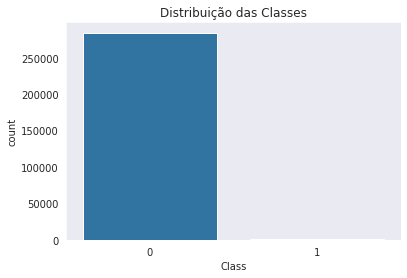

In [25]:
#verificar o balanceamento dos resultados
print(df.Class.value_counts())
print("\nPorcentagem de transações fraudulentas: {:.4%}\n".format(df[df.Class==1].shape[0] / df.shape[0]))

#gráfico para ilustrar as classes das operações
fig, ax = plt.subplots()
sns.countplot("Class", data=df, ax=ax)
ax.set_title("Distribuição das Classes")
plt.show()

#Tratamento dos dados

##Padronização dos dados
Antes de partirmos para o nosso modelo de **Regressão Logística**, devemos tratar as nossas variáveis. 

Isso se deve ao fato de que, embora as variáveis V1 ... V28 já estarem em uma mesma escala, as variáveis `Time` e `Amount` não estão. Portanto é importante que todas as variáveis estejam na mesma escala, para não apresentar nenhum erro no nosso modelo.

In [26]:
#padronização das variáveis Time e Amount

df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1,1))
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1,1))

df_clean.drop(['Time', 'Amount'], axis = 1, inplace=True)

#5 primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_time,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403


##Divisão dos dados
Após isso, dividiremos os nossos dados entre **Treino** e **Teste**. Assim podemos rodar o nosso modelo de *Machine Learing*.

In [27]:
X = df_clean.drop('Class', axis = 1)
y = df_clean['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y)

##Balanceamento dos dados

Chamamos essa discrepância entre as classes 0 (transações genuínas) e 1 (transações fraudulentas) de **Dados Desbalanceados**. 

Se fizermos o nosso modelo de *Machine Learning* para que ele aprenda com esses dados originais, ele será enviesado e terá uma tendência muito maior de classificar a transação como **genuína**, por conta da sua grande quantidade. 

Por isso, é de extrema importância utilizamos técnicas para lidar com esses dados desbalanceados. 

A técnica que iremos utilizar nesse projeto é a de ***Under Sampling***. Resumidamente, o modelo irá eliminar aleatoriamente entradas com a classe majoritária (0) até que seu número se iguale o da classe minoritária (1).

Utilizaremos a biblioteca `imblearn` para fazer o *Under Sampling*, conforme abaixo. 

1    374
0    374
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


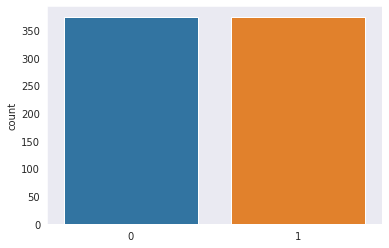

In [28]:
rus = RandomUnderSampler()

X_rus , y_rus = rus.fit_sample(X_train, y_train)

print(pd.Series(y_rus).value_counts())

sns.countplot(y_rus);

#Modelo de *Machine Learning*
Agora que os dados estão "prontos" para serem utilizados, vamos aplicar o modelo de **Regressão Logística**, por ser um tipo de aprendizado supervisionado (existe uma variável alvo: `Class`) e essa variável é dada como "sim" ou "não", ou seja, é de **Classificação**. 

In [29]:
#escolha do modelo de Regressão Logística
from sklearn.linear_model import LogisticRegression

#instanciar a classe do modelo
model = LogisticRegression()

#treinar o modelo
model.fit(X_rus, y_rus)

#aplicar o modelo aos novos dados
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

O modelo foi treinado com os valores resultantes do *under sampling* e para saber o quão bom esse modelo se apresentou, devemos utilizar algumas métricas. 

Abaixo podemos ver no relatório a precisão e o recall. Falaremos dessas métricas na conclusão.

Complementando, a Matriz de Confusão ilustra esse resultado.

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9999    0.9653    0.9823     71084
           1     0.0426    0.9322    0.0815       118

    accuracy                         0.9652     71202
   macro avg     0.5213    0.9487    0.5319     71202
weighted avg     0.9983    0.9652    0.9808     71202



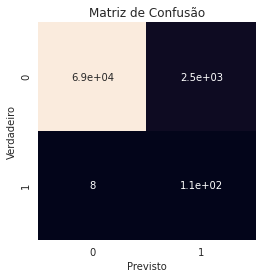

In [50]:
#plotar matriz de confusão
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, square=True)
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Previsto')
ax.set_ylabel('Verdadeiro')
plt.show()

#Conclusão

Podemos concluir que esse modelo de *Machine Learning* nos trouxe um ótimo resultado para identificar quando uma transação é fraudulenta. 

Vamos entrar em um pouco mais de detalhe para entender o que realmente aconteceu.

###Transações genuínas
Como chamamos anteriormente de **`Class` = 0**, essa classificação teve uma Precisão de 99,98%. Isso significa que de **todas** as transações **previstas** como genuínas, 99,98% eram de fato genuínas. 

###Transações fradulentas
Chamada de **`Class` = 1**, a sua Precisão foi de 4,26%, o que segnifica que de todas as transações previstas como fraudulentas, 4,26% eram de fato fraudulentas, o restante podemos chamar de "falsos positivos". 

Mas a característica mais importante aqui é o *Recall*, cujo valor foi de 93,22%. Isso quer dizer que de todas as transações que foram realmente rotuladas como fraude, conseguimos prever 93,22% das vezes. 